# EDA & CDA (Exploratory and Confirmatory Data Analysis)

In this notebook, we explore an airport's dataset (found at [https://catalog.data.gov/uk_UA/dataset/airport-monthly-operational-report]). There are quite a few series obtainable from the dataset, however we will only investigate one, but apply the *airline model* blindly to two other series.

This notebook requires you having read the notebooks for the San Francisco's police dataset, where we have explained the following plots below.

Note that the graphs are (more) readable when plotting via widgets, i.e. changing **'%matplotlib notebook'** to **'%matplotlib tk'** and then restarting the kernel (and re-running everything). Note, however the dataset required is not found within this directory and needs to be downloaded.

## Preliminaries (imports and function definitions)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as stt
from matplotlib import pyplot as plt
from sympy import poly
from sympy.abc import a, b, B

# for jupyter
import sys
sys.path.append('..')

import time_series_funcs.sarima_plus_plus as spp

%matplotlib notebook

In [2]:
def compute_rks(xs):
    # computes the autocorrelation
    N = len(xs)
    n = N - 1
    cnorm = (1 / N)

    c_ks = np.empty(int(N / 2))

    for k in range(int(N / 2)):
        c_ks[k] = cnorm * (xs[:n - (2 * k)] @ xs[k:n - k].T)

    return c_ks / c_ks[0]


def compute_rks2(xs, mean):
    # alternative algorithm to computes autocorrelation
    N = len(xs)
    xs = np.append(xs, np.ones(N) * (-mean))
    c_ks = np.empty(int(N))
    for k in range(N):
        c_ks[k] = (1 / (N - k))
        temp = 0
        for t in range(0, N - k):
            temp += xs[t] * xs[t + k]
        c_ks[k] *= temp

    return c_ks / c_ks[0]


def compute_rks3(ts):
    # alternative algorithm to computes autocorrelation
    dev_from_mean = ts - np.mean(ts)
    autocorr_f = np.correlate(dev_from_mean, dev_from_mean, mode='full')
    rks3 = autocorr_f[int(autocorr_f.size / 2):] / autocorr_f[int(autocorr_f.size / 2)]
    return rks3


def compute_rolling_mean(ts, order=30):
    return pd.Series(ts).rolling(order).mean()


def compute_corr_95(autocorr):
    # computes 95% conf. interval for autocorrelations. Should not be used for the residuals (naively anyway).
    temp = 2 * (autocorr ** 2)
    temp[0] = 1
    temp = np.cumsum(temp)
    return np.sqrt(temp / len(temp))


def compute_safe_conf_95(autocorr):
    # computes 95% conf. interval of autocorrelations. Can be used for ts, or its residuals.
    # plots the ts, the autocorr, and the partial autocorr together.

    # ts: time-series
    # pacf_max: compute pacf for the interval [0,1,2,...,pacf_max]
    # corr_max: present autocorr. for the autocorrelations in the interval [0,1,...,corr_max]
    # ts_is_residuals: Is the time-series the residuals of an original series? (This affects confidence intervals)
    # y_label: label for the y_axis of the time series
    # ts_label: label for the time series itself
    return np.asarray([2 / np.sqrt(len(autocorr))] * len(autocorr))


def create_series_plot(ts: np.ndarray, pacf_max, corr_max=None, ts_is_residuals=False, y_label=None, ts_label=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    if ts_label:
        ax1.plot(ts, label=ts_label)
    else:
        ax1.plot(ts, label='ts')

    ax1.plot(compute_rolling_mean(ts), label='rolling mean every 30t')

    rks3 = compute_rks3(ts)
    if ts_is_residuals:
        se_95 = [2 / np.sqrt(len(rks3))] * len(rks3)
    else:
        se_95 = np.sqrt(compute_corr_95(rks3))

    ax2.plot(rks3, label='corellogram')
    ax2.vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
    ax2.plot(se_95, label='est. est. upper 95% conf. interval')
    ax2.plot(-se_95, label='est. est. lower 95% conf. interval')

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    if corr_max is not None:
        ax2.set_xlim([0, corr_max])

    # remember: pacf calculation can be unstable. Lag_max is a function of convergence: the faster it converges,
    #  the smaller the lag_max possible.
    xs_PACF = stt.pacf(rks3, nlags=pacf_max)
    xs_pacf_SE = np.sqrt(1 / len(rks3))

    ax3.plot(xs_PACF, label='pacf')
    ax3.plot([xs_pacf_SE] * pacf_max, label='est. upper 95% conf. interval')
    ax3.plot([-xs_pacf_SE] * pacf_max, label='est. lower 95% conf. interval')
    ax3.vlines(np.arange(0, len(xs_PACF)), 0, xs_PACF, color="tab:red")

    if y_label:
        ax1.set_ylabel(y_label)
    ax1.set_xlabel('t')
    ax1.legend()

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    ax2.set_ylim([-1, 1])
    ax2.legend()

    ax3.set_ylabel('Pacf.')
    ax3.set_xlabel('t')
    ax3.legend()

    return fig, (ax1, ax2, ax3)


def plot_residuals(ts, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=100, ):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    ts = ts.astype(float)

    if p_poly is not None:
        est_p_poly: poly = poly(p_poly.subs(dict(zip(p_symbols, p_ARIMA_coeffs))), B)
    else:
        est_p_poly = None
    if q_poly is not None:
        est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)
    else:
        est_q_poly = None

    print("est_p_poly:", est_p_poly)
    print("est_q_poly:", est_q_poly)

    # remember: use non-differenced series
    model_err = spp.calculateSeasonalARIMA_error(ts, est_p_poly, d_poly, est_q_poly)

    # step: differencing error, to test if if the noise term is describable by a MA(1) process

    model_err_sec = model_err[:-1] - model_err[1:]

    ax1.plot(model_err_sec, label='consec. differenced residuals')

    rks3 = compute_rks3(model_err_sec)
    res_95 = compute_safe_conf_95(rks3)
    ax2.plot(rks3, label='corellogram')
    ax2.vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
    ax2.plot(res_95, label='est. upper 95% conf. interval, ')
    ax2.plot(-res_95, label='est. lower 95% conf. interval,')

    # remember: pacf calculation can be unstable. Lag_max is a function of convergence: the faster it converges,
    #  the smaller the pacf_max possible.
    ts_pacf = stt.pacf(rks3, nlags=pacf_max)
    ts_pacf_95 = np.sqrt(1 / len(rks3))

    ax3.plot(ts_pacf, label='pacf')
    ax3.plot([ts_pacf_95] * pacf_max, label='est. upper 95% conf. interval')
    ax3.plot([-ts_pacf_95] * pacf_max, label='est. lower 95% conf. interval')
    ax3.vlines(np.arange(0, len(ts_pacf)), 0, ts_pacf, color="tab:red")

    ax1.set_ylabel('Error')
    ax1.set_xlabel('t')
    ax1.legend()

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    ax2.legend()

    ax3.set_ylabel('pacf.')
    ax3.set_xlabel('t')
    ax3.legend()

    return fig, (ax1, ax2, ax3)

## Start of analysis

The series we will study is the number of total passengers over the course of 10 years starting from 2010. A plot of the series is found below.

In [3]:
df = pd.read_csv('Airport_Monthly_Operational_Report.csv')
df = df.sort_values(by=['Month'])
# cargo_total_series = df['Cargo Totals (Cargo + Mail + Belly Freight)'].to_numpy()
# total_op_series = df['Total Operations'].to_numpy()
total_ppl_series = df['Total Passengers'].to_numpy()

<IPython.core.display.Javascript object>


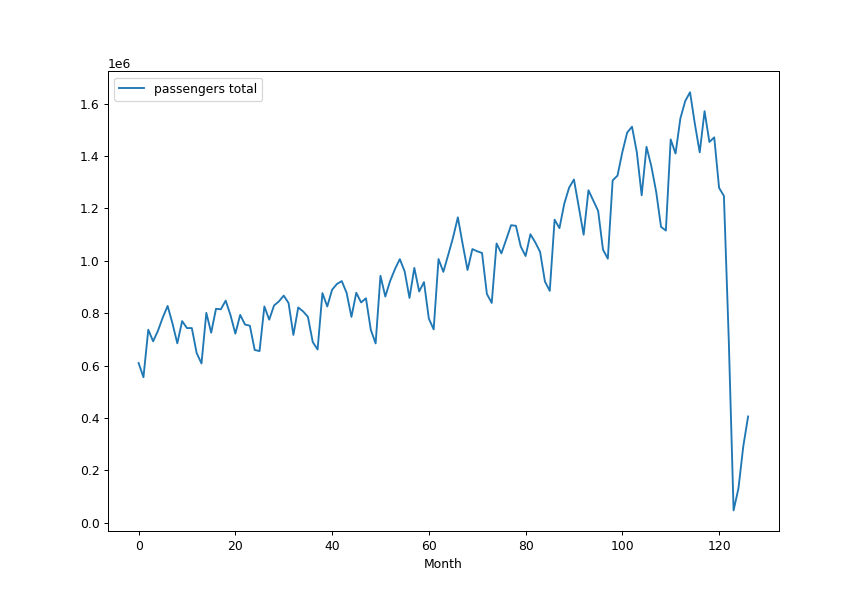

In [4]:
fig, ax = plt.subplots(1)
ax.plot(total_ppl_series, label='passengers total')
ax.set_xlabel("Month")
ax.legend()
plt.show()

## Stationarize series

We create triplots (3 rows of plots) consisting of the series, it's autocorr and partial autocorr. Let us just plot the original series first:

<IPython.core.display.Javascript object>


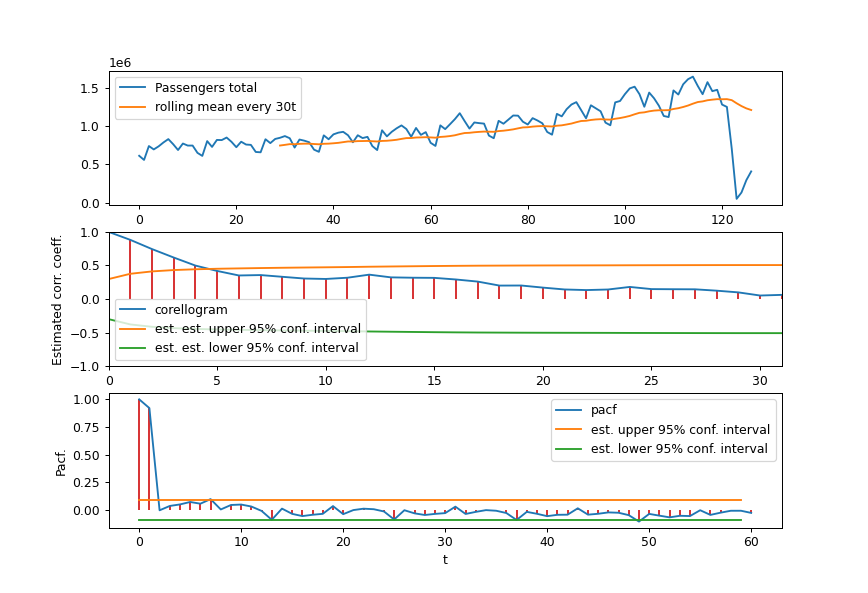

In [5]:
# step: stationarize series
# total_ppl_series = np.log(total_ppl_series) # remember: for stability of variance

create_series_plot(total_ppl_series, pacf_max=60, corr_max=int(len(total_ppl_series) / 4), ts_is_residuals=False,
                   ts_label='Passengers total')
plt.legend()
plt.show()

We find that the series is not stationary. We will have to remove the intervention (for CoVid) and apply a first difference to remove the trend:

In [6]:
# remember: need to remove intervention to determine autocorr properly
# Last seven points correspond to 2020, with last 5 points appear to be affected
orig_total_ppl_series = total_ppl_series
total_ppl_series = total_ppl_series[:-7]

<IPython.core.display.Javascript object>


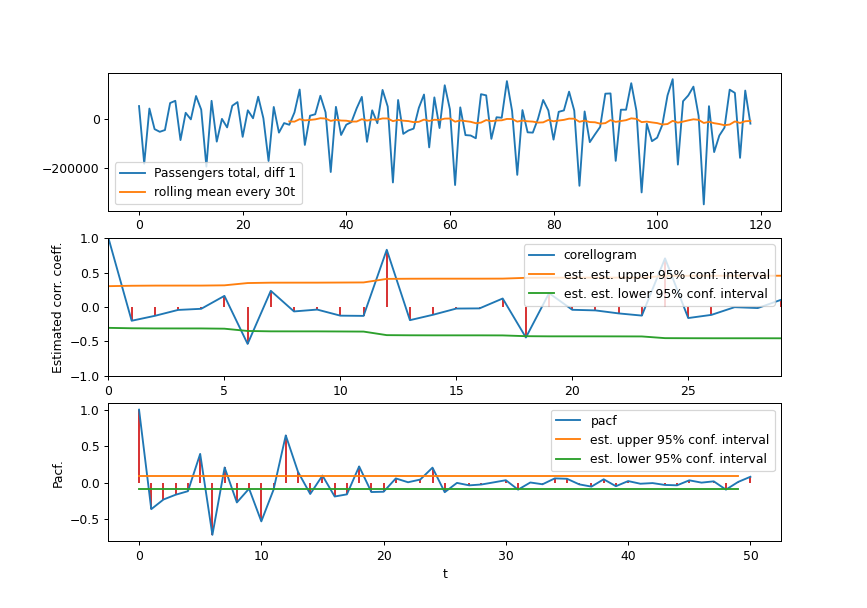

In [7]:
tps_diff = total_ppl_series[:-1] - total_ppl_series[1:]
create_series_plot(tps_diff, pacf_max=50, corr_max=int(len(tps_diff) / 4), ts_is_residuals=False,
                   ts_label='Passengers total, diff 1')
plt.legend()
plt.show()

From our original plot, we know that there is surely a seasonal consisting of 12 months. However the above plot gives the impression that a 6 month seasonal exists too. Let us difference the series for 6 months and study the result:  

<IPython.core.display.Javascript object>


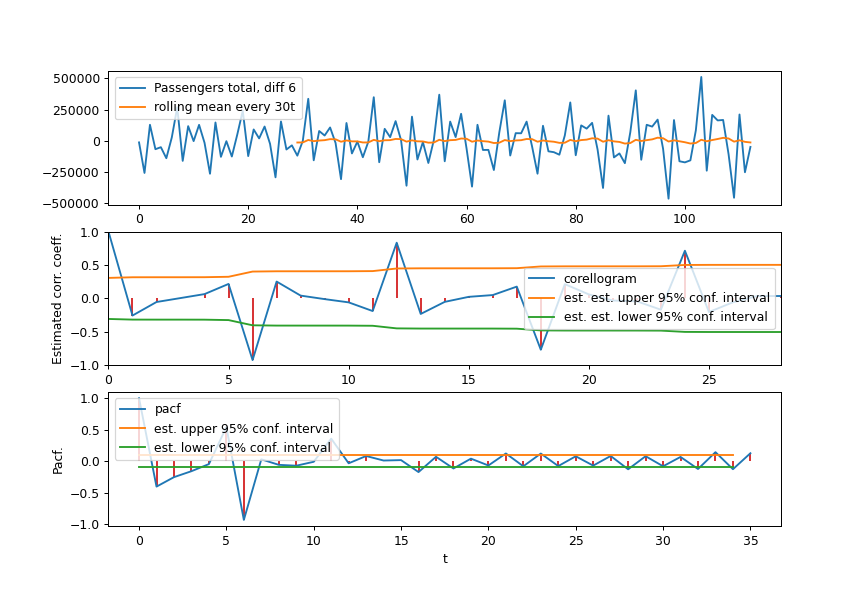

In [8]:
tps_diff_bi_year = tps_diff[:-6] - tps_diff[6:]
create_series_plot(tps_diff_bi_year, pacf_max=35, corr_max=int(len(tps_diff_bi_year) / 4), ts_is_residuals=False,
                   ts_label='Passengers total, diff 6')
plt.legend()
plt.show()

It appears that the differencing has not stationarize the series. Instead now, we just difference the series to remove the 12 month seasonal:

<IPython.core.display.Javascript object>


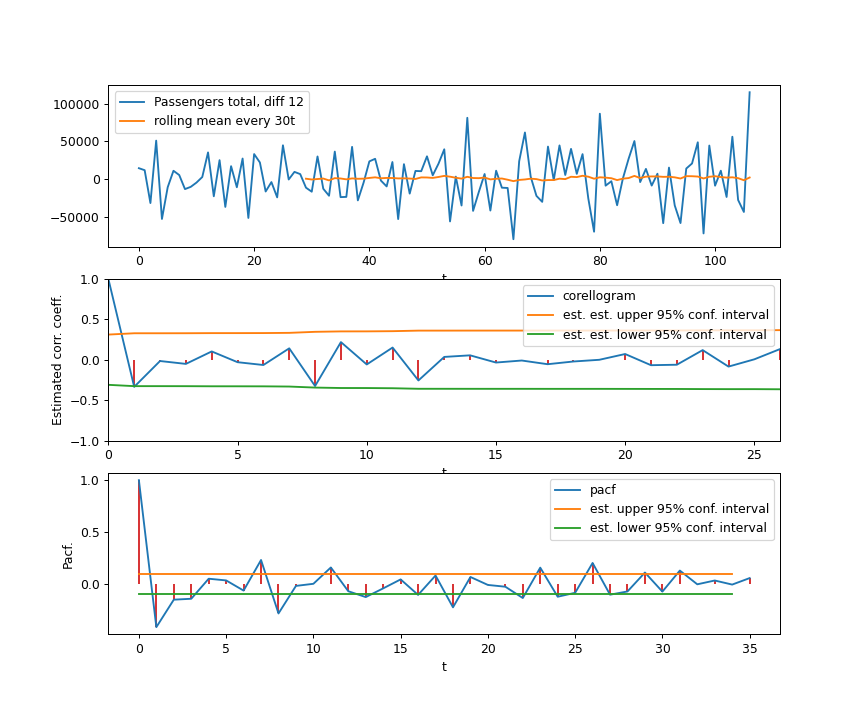

In [9]:
tps_diff_month = tps_diff[:-12] - tps_diff[12:]
create_series_plot(tps_diff_month, pacf_max=35, corr_max=int(len(tps_diff_month) / 4), ts_is_residuals=False,
                   ts_label='Passengers total, diff 12')
plt.legend()
plt.show()

It would appear that the series is now stationary, and that a differencing of 1 & 12 is all that is needed.

## Multiplicative airline model: learn parameters and study residuals

Let us save the last two years of data to check the forecasting capabilities of our model.

In [10]:
# step: split data
# For testing, we further remove 2 years
total_ppl_series = total_ppl_series[:-24]

ts_diff = total_ppl_series[:-1] - total_ppl_series[1:]
ts_diff_year = ts_diff[:-12] - ts_diff[12:]

<IPython.core.display.Javascript object>


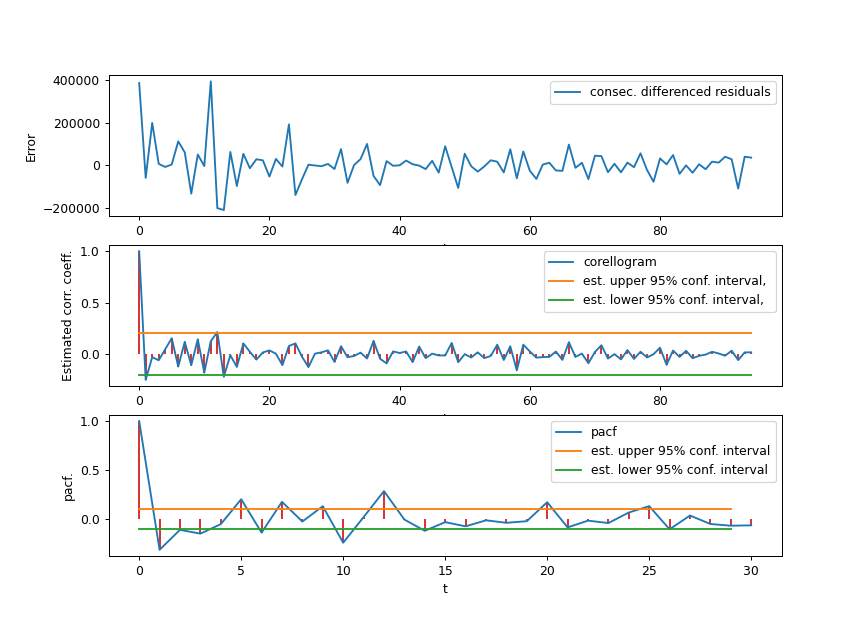

est_p_poly: None
est_q_poly: Poly(0.234322697272284*B**13 - 0.510956212533944*B**12 - 0.45859643453639*B + 1.0, B, domain='RR')


In [11]:
# step: forecast with mul. SARIMA

p_poly = None
q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 12, B)
d_poly = poly(1 - B, B) * poly(1 - B ** 12, B)

p_symbols = []
q_symbols = [a, b]

res = spp.learn_model(ts_diff_year, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

plot_residuals(total_ppl_series, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=30)
plt.show()

The differenced result is almost white noise. However the first lag of the autocorr. is 0.25, not 0.5. 

## Forecast

<IPython.core.display.Javascript object>


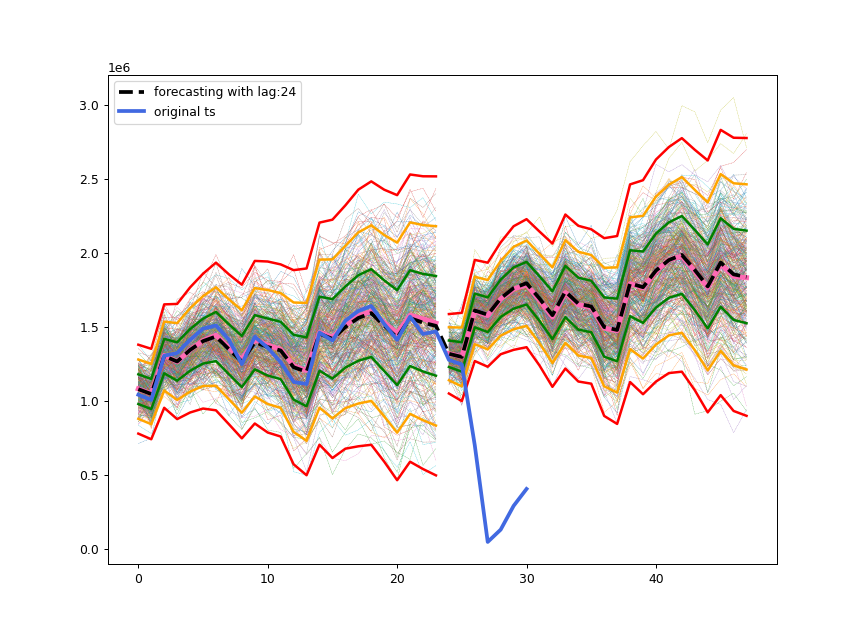

In [12]:
h = 24
est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)

y_h_pieces = spp.stepwise_forecastSeasonalARIMA(total_ppl_series.astype(float), h, None, d_poly, est_q_poly,
                                                orig_total_ppl_series[-31:])

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    total_ppl_series.astype(float), h, None,
    d_poly, est_q_poly, orig_total_ppl_series[-31:],
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=4)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(orig_total_ppl_series[-31:], label='original ts', color='royalblue', linewidth=3)
plt.legend()
plt.show()

The forecast appears quite good. After the 24th month, 2020 begins and the intervention for CoVid appears.

## Additive airline model: learn parameters and study residuals

<IPython.core.display.Javascript object>


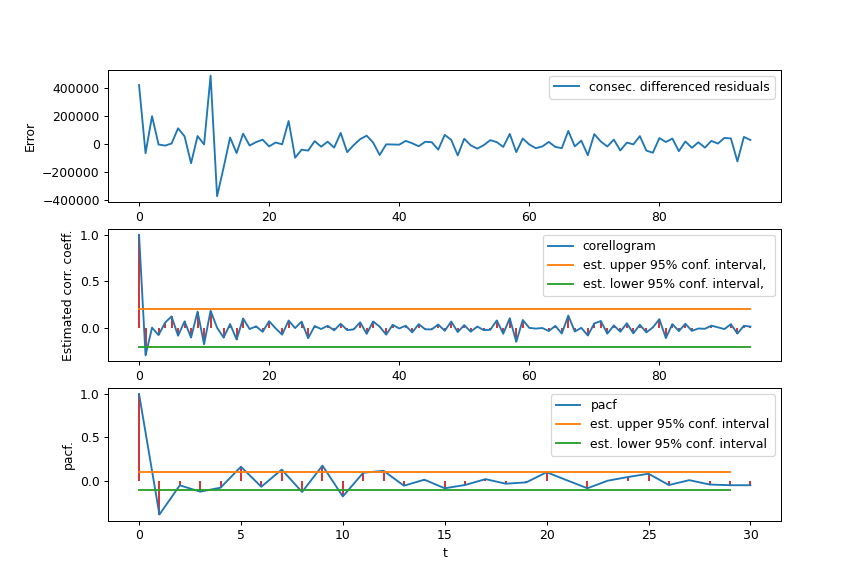

est_p_poly: None
est_q_poly: Poly(-0.352357777279962*B**12 - 0.398720369620039*B + 1.0, B, domain='RR')


In [13]:
q_poly = poly(1 - a * B - b * B ** 12, B)

res = spp.learn_model(ts_diff_year, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

plot_residuals(total_ppl_series, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=30)
plt.show()


The residuals are not too bad.

## Forecast

<IPython.core.display.Javascript object>


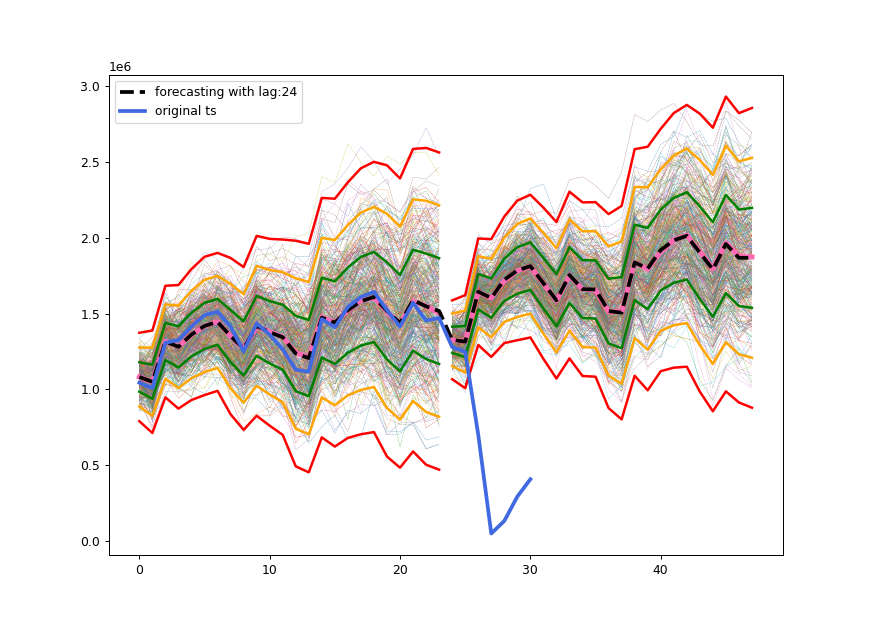

In [14]:
h = 24
est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)

y_h_pieces = spp.stepwise_forecastSeasonalARIMA(total_ppl_series.astype(float), h, None, d_poly, est_q_poly,
                                                orig_total_ppl_series[-31:])

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    total_ppl_series.astype(float), h, None,
    d_poly, est_q_poly, orig_total_ppl_series[-31:],
    num_samples=400)   

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=4)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(orig_total_ppl_series[-31:], label='original ts', color='royalblue', linewidth=3)
plt.legend()
plt.show() 

The forecast is actually quite good.

## Blind application of mul. airline model to other series

Let us apply the airline model to the series: 1) Cargo totals, and 2) Total operations.

### Cargo Totals

<IPython.core.display.Javascript object>


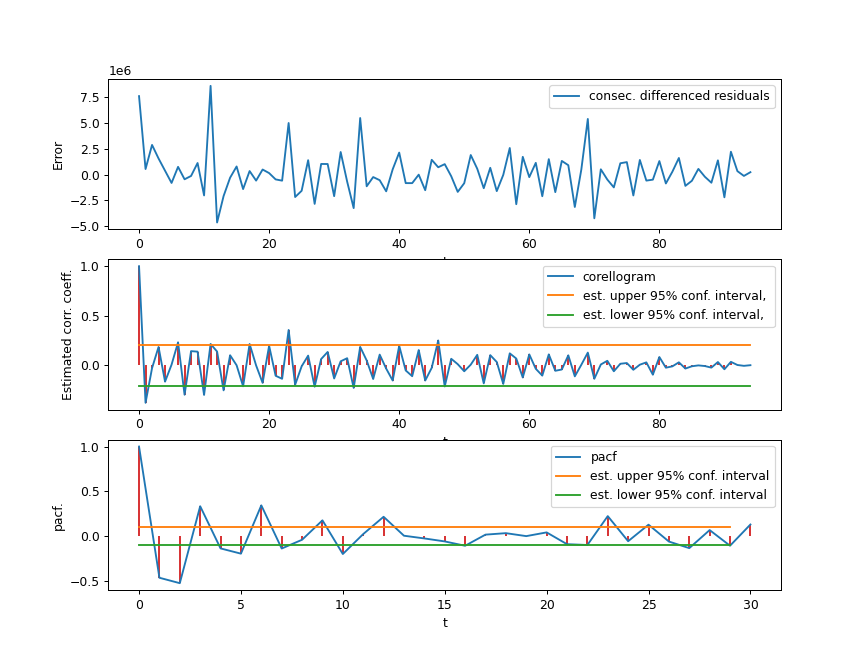

est_p_poly: None
est_q_poly: Poly(0.234324485966068*B**13 - 0.510953088410593*B**12 - 0.458602739235758*B + 1.0, B, domain='RR')


<IPython.core.display.Javascript object>


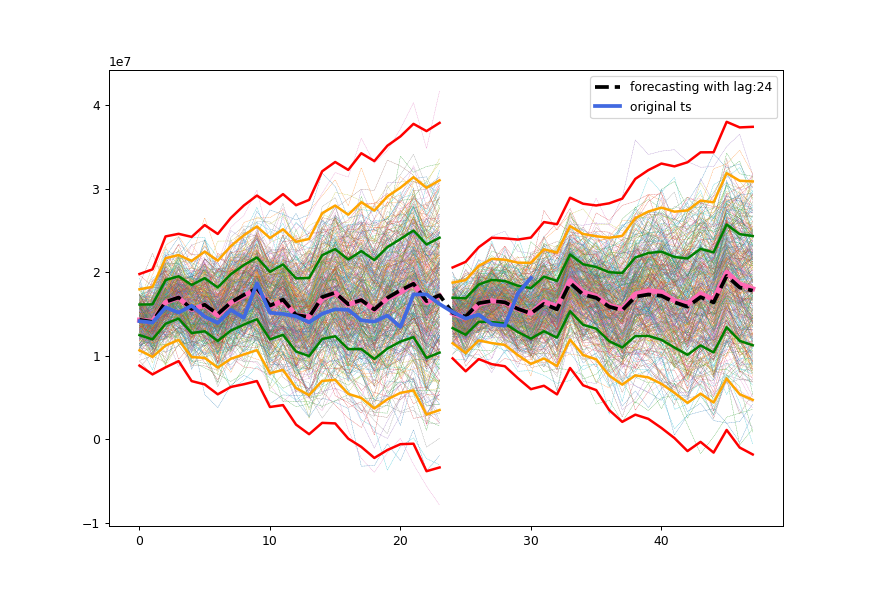

In [15]:
# step: see if other series can be blind forecasted with (mul) airline model :

q_poly = poly(1 - a * B, B) * poly(1 - b * B ** 12, B)

# substep: cargo totals

orig_cargo_total_series = df['Cargo Totals (Cargo + Mail + Belly Freight)'].to_numpy()
cargo_total_series = orig_cargo_total_series[:-(7 + 24)]

res = spp.learn_model(ts_diff_year, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

plot_residuals(cargo_total_series, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=30)
plt.show()

###
h = 24
est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)

y_h_pieces = spp.stepwise_forecastSeasonalARIMA(cargo_total_series.astype(float), h, None, d_poly, est_q_poly,
                                                orig_cargo_total_series[-31:])

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    cargo_total_series.astype(float), h, None,
    d_poly, est_q_poly, orig_cargo_total_series[-31:],
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=4)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(orig_cargo_total_series[-31:], label='original ts', color='royalblue', linewidth=3)
plt.legend()
plt.show()

The fit isn't that good. Looking at the residuals, we might want to study the series a little bit more before trusting the model.

### Total operations

<IPython.core.display.Javascript object>


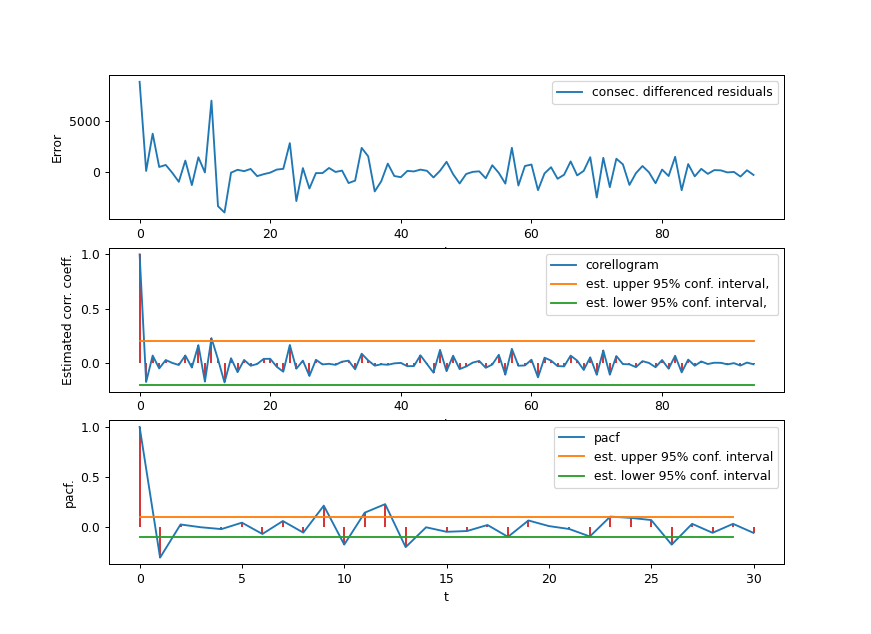

est_p_poly: None
est_q_poly: Poly(0.234323074364646*B**13 - 0.510955548060466*B**12 - 0.458597768933349*B + 1.0, B, domain='RR')


<IPython.core.display.Javascript object>


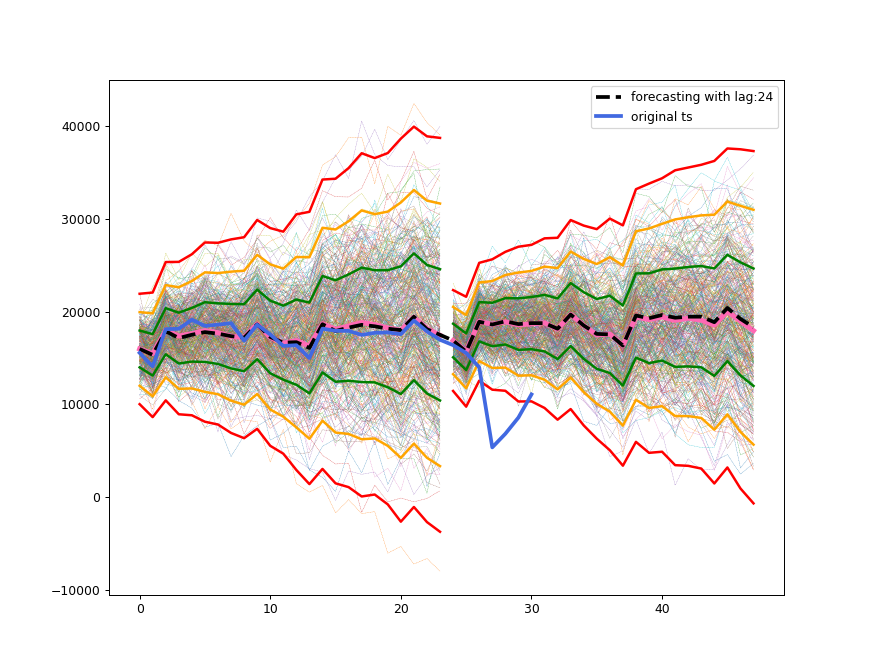

In [16]:
# substep: Total operations

orig_total_op_series = df['Total Operations'].to_numpy()
total_op_series = orig_total_op_series[:-(7 + 24)]

res = spp.learn_model(ts_diff_year, p_poly, q_poly, p_symbols, q_symbols)

ARIMA_coeffs = res.x
p_ARIMA_coeffs = ARIMA_coeffs[:len(p_symbols)]
q_ARIMA_coeffs = ARIMA_coeffs[-len(p_symbols):]

plot_residuals(total_op_series, p_poly, q_poly, d_poly, p_ARIMA_coeffs, q_ARIMA_coeffs, pacf_max=30)
plt.show()

###
h = 24
est_q_poly: poly = poly(q_poly.subs(dict(zip(q_symbols, q_ARIMA_coeffs))), B)

y_h_pieces = spp.stepwise_forecastSeasonalARIMA(total_op_series.astype(float), h, None, d_poly, est_q_poly,
                                                orig_total_op_series[-31:])

y_h_multistep, y_h_step_stds, y_h_steps_means = spp.batch_stepwise_forecastSeasonalARIMA(
    total_op_series.astype(float), h, None,
    d_poly, est_q_poly, orig_total_op_series[-31:],
    num_samples=400)

fig, ax = plt.subplots(1)

for i in range(y_h_multistep.shape[0]):
    for j in range(y_h_multistep.shape[1]):
        ax.plot(np.arange((i * h), (i + 1) * h), y_h_multistep[i, j], linewidth=0.25, linestyle='--')
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + y_h_step_stds[i], color='green',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - y_h_step_stds[i], color='green',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 2 * y_h_step_stds[i], color='orange',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 2 * y_h_step_stds[i], color='orange',
            linewidth=2)

    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] + 3 * y_h_step_stds[i], color='red',
            linewidth=2)
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_pieces[(i * h):(i + 1) * h] - 3 * y_h_step_stds[i], color='red',
            linewidth=2)

for i in range(y_h_multistep.shape[0]):
    ax.plot(np.arange((i * h), (i + 1) * h), y_h_steps_means[i], color='hotpink', linewidth=4)

ax.plot(y_h_pieces, label='forecasting with lag:' + str(h), color='black', linewidth=3, linestyle='--')
ax.plot(orig_total_op_series[-31:], label='original ts', color='royalblue', linewidth=3)
plt.legend()
plt.show()

This forecast appears to be quite good, however the first lag of the autocorr (of the first-differenced residual) is quite small.

## Summary

The airline model is well known within literature and books. They appear to work quite well for such a dataset (i.e. airline dataset).